# Advanced ASR Techniques

In this notebook, we'll cover the essential steps of handling audio data for speech recognition tasks, dive into MFCCs transcribing speech using Whisper and noise reduction

### Feature Extraction

In [6]:
import librosa
import IPython.display as ipd

# Load an audio file as a floating point time series
audio_path = 'data/audio.wav'
audio_data, sampling_rate = librosa.load(audio_path, sr=None)  # sr=None ensures original sampling rate is preserved

# Display basic information about the audio
print(f"Audio duration: {audio_data.shape[0] / sampling_rate:.2f} seconds")
print(f"Sampling rate: {sampling_rate} Hz")

Audio duration: 7.47 seconds
Sampling rate: 16000 Hz


In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd


def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    print(f"Loaded audio file '{file_path}'")
    print(f"Sample rate: {sample_rate}")
    print(f"Waveform tensor shape: {waveform.shape}")
    return waveform, sample_rate

# Example usage
audio_path = file_path = 'data/audio.wav'
waveform, sample_rate = load_audio(audio_path)


Loaded audio file 'data/audio.wav'
Sample rate: 16000
Waveform tensor shape: torch.Size([1, 119537])


In [5]:
# Play the loaded audio file
ipd.Audio(waveform, rate=sampling_rate)


Sampling is the process of recording the amplitude of a sound wave at discrete intervals. The sample rate defines how many samples per second are recorded.
The choice of sample rate affects the accuracy of the speech features captured. A higher sample rate can capture more detail but requires more computational resources. 


### Visualizing Audio Data

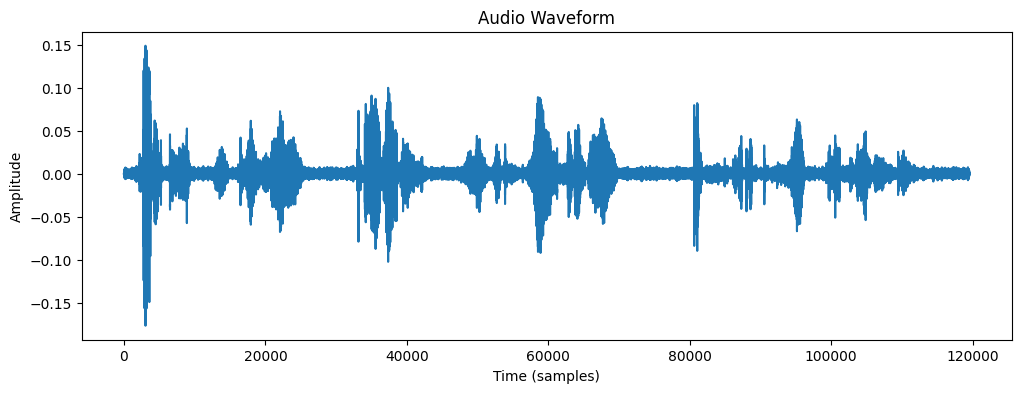

In [6]:
import matplotlib.pyplot as plt

# Plotting the waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title('Audio Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()


### Audio Pre-processing

Speech recognition systems often require specific audio preprocessing steps to improve the accuracy of recognition. Common steps include:
- Resampling: Changing the sample rate of the audio file. This is often necessary to standardize the input data to a consistent format expected by downstream processes or models.
- Normalization: Scaling the audio waveform so that the amplitude ranges within a specific interval, typically between -1 and 1. This helps in reducing disparities in volume and amplitude between different audio recordings

In [7]:
def preprocess_audio(waveform, new_sample_rate=16000):
    # Resample
    if waveform.shape[1] != new_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
        waveform = resampler(waveform)
        print(f"Resampled waveform to {new_sample_rate} Hz")

    # Normalize audio to [-1, 1]
    waveform = waveform / torch.max(torch.abs(waveform))
    return waveform

waveform = preprocess_audio(waveform, new_sample_rate=16000)


Resampled waveform to 16000 Hz


Pre-processing standardizes the audio inputs, which helps in reducing variability that is not related to the linguistic content of the speech. For example, models trained with data at a consistent sample rate and amplitude are more stable and perform better in recognizing speech from various sources.

#### Feature Extraction

Feature extraction is a crucial step in speech recognition. It transforms raw audio data into a more compact and representative format that is easier for ASR models to process. There are several features commonly used:

- **Spectrograms**: A spectrogram is a visual representation of the spectrum of frequencies in a sound as they vary with time. It is obtained by applying a Fourier transform (FFT) across short time windows of the waveform.

- **Mel Spectrograms**: This involves converting the frequency scale of the spectrogram to the Mel scale, which more closely approximates human auditory perception's response to different frequencies. The frequencies are spaced evenly according to the Mel scale, which is a perceptual scale of pitches judged by listeners to be equal in distance from one another.

- Mel-frequency cepstral coefficients (**MFCCs**): MFCCs are perhaps the most widely used feature extraction method in speech recognition systems. They are derived from the logarithm of the Mel spectrogram followed by a discrete cosine transform (DCT). They provide a compact representation of the audio based on the power spectrum of a signal.

**Role of `n_mfcc`**

- `n_mfcc` Parameter: This parameter specifies how many of the resulting cepstral coefficients are returned after the DCT. The first coefficient, which represents the mean energy of the signal, is usually discarded because it carries less information about the spectral shape.
- Choosing `n_mfcc`: The number of coefficients to use is a trade-off between having enough coefficients to capture the important characteristics of the audio signal and not having so many that the dimensionality becomes too high, which could lead to overfitting in machine learning models. Typically, 12 to 20 MFCCs are used in speech recognition tasks.
- In the above code `n_mfcc` was set to 13. This means the MFCC computation process will extract the first 13 coefficients for each frame


/Users/waseem/Desktop/Files/Tribe/venv_ml/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


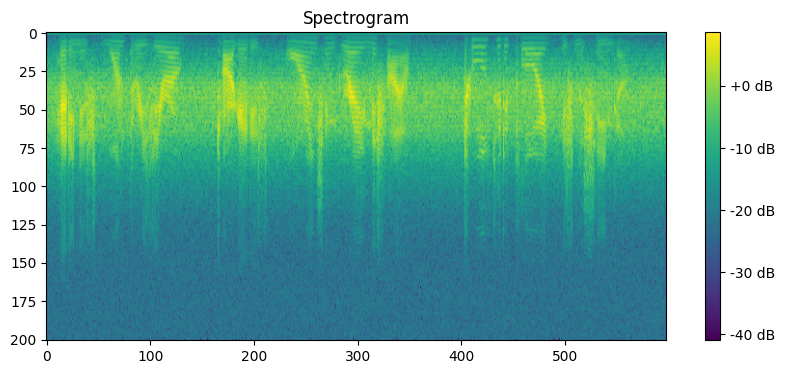

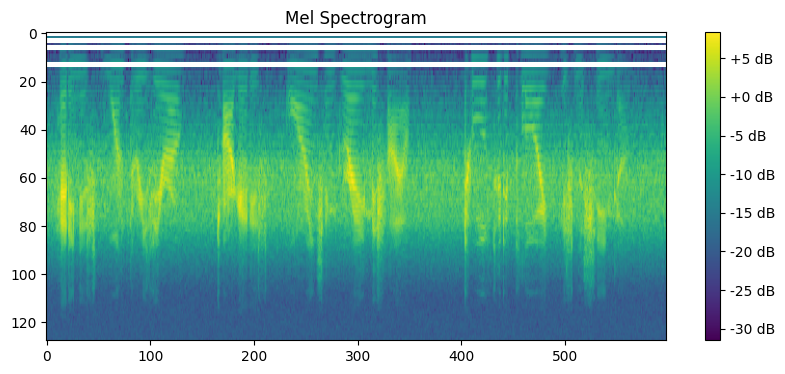

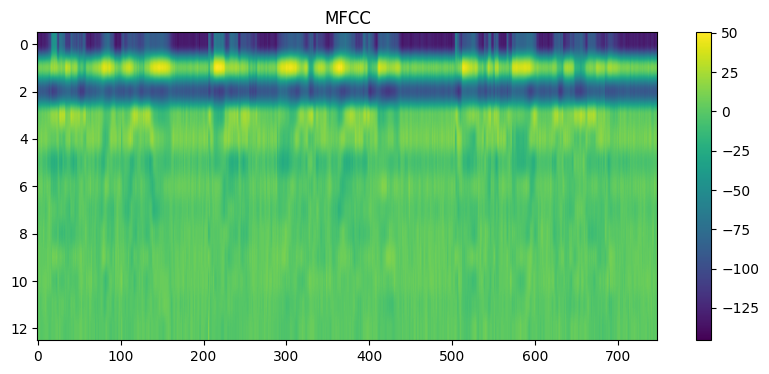

In [8]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T

def extract_features(waveform, sample_rate, n_mfcc=13):
    # Compute standard Spectrogram
    spectrogram_transform = T.Spectrogram()
    spectrogram = spectrogram_transform(waveform)
    
    # Compute Mel Spectrogram
    mel_spectrogram_transform = T.MelSpectrogram(sample_rate=sample_rate)
    mel_spectrogram = mel_spectrogram_transform(waveform)
    
    # Compute MFCCs from Mel Spectrogram
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23})
    mfccs = mfcc_transform(waveform)
    
    return spectrogram, mel_spectrogram, mfccs

# Example usage (assuming 'waveform' and 'sample_rate' are already defined)
spectrogram, mel_spectrogram, mfccs = extract_features(waveform, sample_rate=16000)

# Plot the standard Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram.log2()[0,:,:].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.log2()[0,:,:].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot the MFCCs
plt.figure(figsize=(10, 4))
plt.imshow(mfccs[0,:,:].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('MFCC')
plt.colorbar()
plt.show()


**Importance for ASR:**

These features are crucial because they transform the audio into a form that emphasizes characteristics important for distinguishing between different phonemes (sounds) in speech. This transformation is beneficial because:

**Spectrograms** provide a time-frequency representation, capturing when certain sounds occur and their frequencies, which are essential cues for understanding speech.

**Mel Spectrograms** emphasize perceptually important frequencies, making it easier for the model to focus on parts of the audio that are more likely to carry linguistic content.

**MFCCs** capture the timbral and envelope characteristics of sound. They emphazie aspects of sound as perceived by the human ear. They are widely used in ASR because they effectively represent the vocal tract configuration that determines how we pronounce sounds, thus capturing the linguistic content effectively.

### Whisper

Whisper is an automatic speech recognition (ASR) system developed by OpenAI.  It's designed to provide robust transcription capabilities across various audio inputs, languages, and domains. Whisper utilizes transformer architecture to provide robust transcription capabilities across various languages and audio conditions. The model can handle different accents, background noises, and audio qualities, making it highly versatile for practical applications.

<img src="https://lh3.googleusercontent.com/d/1JFd1l7FvXPGweUQZ1PmgqBYI_c_DpgGI" alt="drawing" width="750">

Let us first load the Whisper model to transcribe an audio file to extract text directly from the original recording.

In [15]:
import whisper

model = whisper.load_model("base")
result = model.transcribe('data/audio.wav', fp16 = False)

result['text']

' Headiness 130, Target is orange and gray missile. Tool to deploy is machine gun.'

In [16]:
# Play the loaded audio file
audio_path = 'data/audio.wav'
audio_data, sampling_rate = librosa.load(audio_path, sr=None) 

audio_path = file_path = 'data/audio.wav'
waveform, sample_rate = waveform, sample_rate = torchaudio.load(file_path)
ipd.Audio(waveform, rate=sampling_rate)


Loaded audio file 'data/audio.wav'
Sample rate: 16000
Waveform tensor shape: torch.Size([1, 119537])


#### Noise Reduction
 To improve transcription quality, we reduce background noise using `noisereduce` libraries. 

In [11]:
import noisereduce as nr
import librosa
import soundfile as sf

# Load audio file
audio_path = 'data/audio.wav'
audio, rate = librosa.load(audio_path, sr=None)

# Perform noise reduction
noisy_part = audio[0:int(rate*0.5)]  # Identify the noisy part
reduced_noise_audio = nr.reduce_noise(y=audio, sr=rate, y_noise=noisy_part)

# Save the cleaned audio
clean_audio_path = 'data/cleaned_audio.wav'
sf.write(clean_audio_path, reduced_noise_audio, rate)
result = model.transcribe('data/cleaned_audio.wav', fp16 = False)

result['text']

' heading is 1-3-0 target is orange and gray missiles tool to deploy is machine gun'

- `audio[0:int(rate * 0.5)]`: This line isolates a portion of the audio data assumed to be noisy.
- The expression `int(rate * 0.5)` calculates the number of audio samples that represent the first 0.5 seconds of the recording. This initial segment is used as the reference noise profile.
- `nr.reduce_noise`: This function from the noisereduce library takes the original audio `(y=audio)` and the isolated noisy segment ` (y_noise=noisy_part)` to reduce background noise.

In [19]:
# Play the cleaned audio file
audio_path = 'data/cleaned_audio.wav'
waveform, sample_rate = load_audio(audio_path)
ipd.Audio(waveform, rate=sampling_rate)

Loaded audio file 'data/cleaned_audio.wav'
Sample rate: 16000
Waveform tensor shape: torch.Size([1, 119537])


The difference between the original and cleaned transcriptions you've provided can be attributed to the effects of noise reduction and the improved clarity it brings to the speech recognition process.

### Conclusion

In this notebook, we learnt to extract relevant audio features such as Mel-Frequency Cepstral Coefficients (MFCCs) to better understand the nature of the audio. We saw how Whisper model's advanced transformer architecture, combined with appropriate audio pre-processing and noise reduction , can deliver accurate and reliable transcriptions even in noisy environments.